In [141]:
def manhattan(src, dst):
    dee = 0
    for s, d in zip(src, dst):
        dee += abs(d - s)
    return dee


def astar(src, dst, maze, moveset):
    openlist = [[manhattan(src, dst), 0, src[0], src[1]]]
    visitlist = []
    parents = {}
    
    done = False
    while len(openlist) > 0 and not done:
        visiting = openlist[0]
        visitlist.append((visiting[2], visiting[3]))

        for move in moveset:
            neighbour = (visiting[2]+move[0], visiting[3]+move[1])
            if neighbour[0] == dst[0] and neighbour[1] == dst[1]:
                done = True
            elif not (neighbour in maze.keys()):
                continue
            elif maze[neighbour] == 0:
                continue
            if not (neighbour in visitlist):
                h = manhattan(neighbour, dst)
                g = visiting[1] + 1
                openlist.append([h+g, g, neighbour[0], neighbour[1]])
                parents[neighbour] = (visiting[2], visiting[3])
                if done:
                    break
        openlist = openlist[1:]
        openlist.sort()
        
    if done:
        path = []
        visiting = dst
        
        builddone = False
        while not builddone:
#             print('visiting', visiting)
            if visiting[0] == src[0] and visiting[1] == src[1]:
                builddone = True
                break
                
            parent = parents[visiting]
            dx = visiting[0] - parent[0]
            dy = visiting[1] - parent[1]
            
            move = moveset.index([dx, dy])+1
            path.append(move)
            
            visiting = parent
        path.reverse()
        return path
    else:
        print('cannot find path from {} to {}'.format(src, dst))
        return []
    

def handle_report(sense):
    global next_move
    global robopose
    global pre_robopose
    global mazemap
    
    coordinate = (robopose[0]+next_move[0],
                  robopose[1]+next_move[1])
    
    if sense == 0:
        mazemap[coordinate] = 0
    elif sense == 1:
        mazemap[coordinate] = 1
        prev_robopose[0] = robopose[0]
        prev_robopose[1] = robopose[1]
        robopose[0] += next_move[0]
        robopose[1] += next_move[1]
    elif sense == 2:
        mazemap[coordinate] = 2
        prev_robopose[0] = robopose[0]
        prev_robopose[1] = robopose[1]
        robopose[0] += next_move[0]
        robopose[1] += next_move[1]
        print('oxy system found in', robopose)
#     print('pose', robopose, 'sense', sense)
    return


def decide_move():
    global next_move
    global robopose
    global pre_robopose
    global mazemap
    global openlist
    global sequence
    
    moveset = [[0, 1], [0, -1], [-1, 0], [1, 0]]
    
    if len(sequence) > 0:
        direction = sequence[0]
        sequence = sequence[1:]
        next_move = moveset[direction-1]
        return direction    
    
    for move in moveset:
        next_robopose = (robopose[0]+move[0], robopose[1]+move[1])
        if not (next_robopose in mazemap.keys()):
            if not (next_robopose in openlist):
#                 print('now in', robopose, 'add', next_robopose, 'to open list')
                openlist = [next_robopose] + openlist
    
    if len(openlist) == 0:
        return 0
    
    dx = openlist[0][0] - robopose[0]
    dy = openlist[0][1] - robopose[1]
    
    if abs(dx) + abs(dy) == 1:
#         print('move', next_move)
        next_move = [dx, dy]
        openlist = openlist[1:]
        return moveset.index(next_move) + 1
    else:
        path = astar(robopose, openlist[0], mazemap, moveset)
#         print('find path from {} to {}'.format(robopose, openlist[0]))
#         print(path)
        openlist = openlist[1:]
        sequence = path[1:]
        next_move = moveset[path[0]-1]
        return path[0]

In [142]:
def resolve_arg(program, argmode, base_offset, i, j):    
    if argmode == 0:
        return program[i+j]
    elif argmode == 1:
        return i+j
    elif argmode == 2:
        return base_offset + program[i+j]

def intcode(program, inlist=[], i=0):
    global next_move
    global robopose
    global pre_robopose
    global mazemap
    global openlist

    outbuf = []
    base_offset = 0
    
    while True:
        if i >= len(program):
            print('end of program')
            return program
        opcode = program[i]
        
        op = opcode % 100
        argmodes = []
        argcode = opcode // 100
        while argcode > 0:
            argmodes.append(argcode % 10)
            argcode = argcode // 10
            
        # ADD A B -> C
        # --------------------------------------------------------
        if op == 1:
            if len(argmodes) < 1:
                idx1 = resolve_arg(program, 0, base_offset, i, 1)
            else:
                idx1 = resolve_arg(program, argmodes[0], base_offset, i, 1)
            
            if len(argmodes) < 2:
                idx2 = resolve_arg(program, 0, base_offset, i, 2)
            else:
                idx2 = resolve_arg(program, argmodes[1], base_offset, i, 2)
            
            if len(argmodes) < 3:
                idx3 = resolve_arg(program, 0, base_offset, i, 3)
            else:
                idx3 = resolve_arg(program, argmodes[2], base_offset, i, 3)

            bigdex = max([idx1, idx2, idx3])
            if len(program) <= bigdex:
                program += [0]*(bigdex - len(program) + 1)
                
            arg1 = program[idx1]
            arg2 = program[idx2]                
            
            program[idx3] = arg1 + arg2
            i += 4
        # MULTIPLY A B ->
        # --------------------------------------------------------
        elif op == 2:
            if len(argmodes) < 1:
                idx1 = resolve_arg(program, 0, base_offset, i, 1)
            else:
                idx1 = resolve_arg(program, argmodes[0], base_offset, i, 1)
            
            
            if len(argmodes) < 2:
                idx2 = resolve_arg(program, 0, base_offset, i, 2)
            else:
                idx2 = resolve_arg(program, argmodes[1], base_offset, i, 2)

            if len(argmodes) < 3:
                idx3 = resolve_arg(program, 0, base_offset, i, 3)
            else:
                idx3 = resolve_arg(program, argmodes[2], base_offset, i, 3)
                
            bigdex = max([idx1, idx2, idx3])
            if len(program) <= bigdex:
                program += [0]*(bigdex - len(program) + 1)
                
            arg1 = program[idx1]
            arg2 = program[idx2]
            
            program[idx3] = arg1 * arg2
            i += 4
        # INPUT -> A
        # --------------------------------------------------------
        elif op == 3:
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx = resolve_arg(program, argmode, base_offset, i, 1)
            
            if len(program) <= idx:
                program += [0]*(idx - len(program) + 1)

            if len(inlist) > 0:
                program[idx] = inlist[0]
                inlist = inlist[1:]
            else:
                direction = decide_move()
                if direction == 0:
                    print('exploration is complete')
                    return outbuf
                
                program[idx] = direction
            i += 2
        # OUTPUT A
        # --------------------------------------------------------
        elif op == 4:
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx = resolve_arg(program, argmode, base_offset, i, 1)
            outbuf.append(program[idx])
            handle_report(program[idx])
            if program[idx] == 2:
                print('found oxy system')
            i += 2
        # JUMP TRUE A != 0 -> B
        # --------------------------------------------------------
        elif op == 5:                
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx1 = resolve_arg(program, argmode, base_offset, i, 1)
            
            argmode = 0 if len(argmodes) < 2 else argmodes[1]
            idx2 = resolve_arg(program, argmode, base_offset, i, 2)
            
            bigdex = max([idx1, idx2])
            if len(program) <= bigdex:
                program += [0]*(bigdex - len(program) + 1)
            
            arg1 = program[idx1]
            arg2 = program[idx2]    
            if arg1 != 0:
                i = arg2
            else:
                i += 3
        # JUMP FALSE A == 0 -> B
        # --------------------------------------------------------
        elif op == 6:
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx = resolve_arg(program, argmode, base_offset, i, 1)
            arg1 = program[idx]
            
            argmode = 0 if len(argmodes) < 2 else argmodes[1]
            idx = resolve_arg(program, argmode, base_offset, i, 2)
            arg2 = program[idx]
            
            if len(program) <= arg2:
                program += [0]*(arg2-len(program)+1)
                
            if arg1 == 0:
                i = arg2
            else:
                i += 3
        # LESS THAN A < B 1 -> C
        # --------------------------------------------------------
        elif op == 7:
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx = resolve_arg(program, argmode, base_offset, i, 1)
            arg1 = program[idx]
            
            argmode = 0 if len(argmodes) < 2 else argmodes[1]
            idx = resolve_arg(program, argmode, base_offset, i, 2)
            arg2 = program[idx]
            
            argmode = 0 if len(argmodes) < 3 else argmodes[2]
            idx = resolve_arg(program, argmode, base_offset, i, 3)
                
            if len(program) <= idx:
                program += [0]*(idx-len(program)+1)
                
            if arg1 < arg2:
                program[idx] = 1
            else:
                program[idx] = 0
            i += 4
        # EQUALS A == B 1 -> C
        # --------------------------------------------------------
        elif op == 8:
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx = resolve_arg(program, argmode, base_offset, i, 1)
            arg1 = program[idx]
            
            argmode = 0 if len(argmodes) < 2 else argmodes[1]
            idx = resolve_arg(program, argmode, base_offset, i, 2)
            arg2 = program[idx]
            
            argmode = 0 if len(argmodes) < 3 else argmodes[2]
            idx = resolve_arg(program, argmode, base_offset, i, 3)
                
            if len(program) <= idx:
                program += [0]*(idx-len(program)+1)
                
            if arg1 == arg2:
                program[idx] = 1
            else:
                program[idx] = 0
            i += 4
        # SHIFT RELATIVE BASE
        # --------------------------------------------------------
        elif op == 9:
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx = resolve_arg(program, argmode, base_offset, i, 1)
            arg1 = program[idx]
            base_offset += arg1
            if len(program) <= base_offset:
                program += [0]*(base_offset-len(program)+1)
            i += 2
        # HALT
        # --------------------------------------------------------
        elif op == 99:
            return outbuf
        # INVALID
        # --------------------------------------------------------
        else:
            print(program[i], 'is not an instruction')
            return outbuf

In [143]:
with open('calca_15_input.txt', 'r') as infile:
    progstring = [row for row in infile][0]
    program = [int(op) for op in progstring.split(',')]
    
robopose = [0, 0]
prev_robopose = [0, 0]
next_move = [1, 0]
mazemap = {(0, 0): 1}
openlist = []
movelist = []
sequence = []

obuf = intcode(program)

oxy system found in [-20, 14]
found oxy system
oxy system found in [-20, 14]
found oxy system
exploration is complete


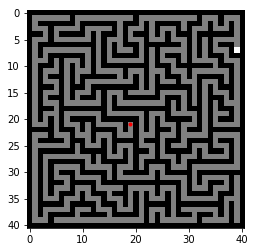

In [144]:
%matplotlib inline
import numpy as np
import matplotlib.image as mpim
import matplotlib.pyplot as plt
xmap = np.array(list(mazemap.keys()))

ymin = xmap[:, 1].min()
ymax = xmap[:, 1].max()
xmin = xmap[:, 0].min()
xmax = xmap[:, 0].max()

gmap = np.zeros([ymax-ymin+1, xmax-xmin+1])

for c in xmap:
    gmap[c[1]-ymin, c[0]-xmin] = mazemap[(c[0], c[1])]
    
plt.imshow(np.fliplr(np.flipud(gmap)), cmap='gray')
plt.plot(xmax, ymax, 'r.')

In [145]:
oxy = (-20, 14)
maxdee = 0
for coordinate in mazemap.keys():
    if mazemap[coordinate] == 1:
        path = astar(oxy, coordinate, mazemap, [[0, 1], [0, -1], [-1, 0], [1, 0]])
        if len(path) > maxdee:
            maxdee = len(path)
            
print(maxdee)

332


In [132]:
path = astar((0, 0), (-20, 14), mazemap, [[0, 1], [0, -1], [-1, 0], [1, 0]])
print(len(path), path)

250 [2, 2, 4, 4, 1, 1, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 1, 1, 3, 3, 2, 2, 2, 2, 3, 3, 1, 1, 3, 3, 2, 2, 2, 2, 4, 4, 2, 2, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 4, 4, 4, 4, 2, 2, 4, 4, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 2, 2, 3, 3, 2, 2, 4, 4, 4, 4, 1, 1, 4, 4, 2, 2, 4, 4, 2, 2, 4, 4, 1, 1, 4, 4, 1, 1, 1, 1, 3, 3, 1, 1, 4, 4, 1, 1, 4, 4, 2, 2, 2, 2, 4, 4, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 2, 2, 4, 4, 2, 2, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 4, 4, 1, 1, 3, 3, 3, 3, 2, 2]
